# Question 3 - Part1
The basic structure of the code is an excerpt of the baseline. The fundamental model given already is used as a foundation on which we perform:
1) Batch Norm
2) Adding new layers
3) With Dropout
4) Different activation functions at the end
5) Different pooling strategies•Different optimizers
6) Basic Augmentation like Rotation, Translation, Color Change

Implement Batch Norm

#### Import all the packages

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim


from sklearn import preprocessing
from sklearn.metrics import f1_score,precision_score,log_loss


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [2]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [3]:
table = pd.read_csv('data/train/train.csv')
Label_Encode = preprocessing.LabelEncoder()
Labels = Label_Encode.fit_transform(table['ClassName'])
trainData = table
trainData['ClassName'] = Labels
print(trainData)

             ImageId  ClassName
0     f27632d7e5.jpg         55
1     efa87919ed.jpg         41
2     4f169e8c8d.jpg         12
3     a6956654bf.jpg         44
4     d99ce8c3bf.jpg         23
...              ...        ...
9318  ba8233c7d2.jpg          7
9319  2090043907.jpg         58
9320  8762d1cefd.jpg         14
9321  28e7439245.jpg         12
9322  ba263cfb41.jpg         21

[9323 rows x 2 columns]


#### **Data Augmentation**

In [4]:

# augData = trainData.copy(deep=True)
# trainData['augData'] =  [0]*len(trainData)
# augData['augData'] = [1]*len(augData)
# combo = pd.concat([trainData,augData],ignore_index=True)
# print(combo)
# # print(combo[9318:9322])

In [5]:
class FoodData(Dataset):
    def __init__(self,dataFile,fileDir,transform=None,train=True):
        super().__init__()
        self.data_list = dataFile
        self.data_dir = fileDir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
            img_name = self.data_list.iloc[item]['ImageId']
            label = self.data_list.iloc[item]['ClassName']
        else:
              img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform:
            img = self.transform(img)
            
#         augValue = self.data_list.iloc[item,-1]
#         if augValue == 1:
#             img = cv2.flip(img, 0)
        if self.train:
              return {'ImgVals' : img, 'labelId' : torch.tensor(label)}
        else:
              return {'ImgVals':img}

Instanciate the training data class

In [6]:
trainPath = 'data/train/train_images'

train_data = FoodData(dataFile = trainData,
                           fileDir = trainPath,
                           transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
                            ]))
print(train_data)

Split train_data object into training, validation

In [7]:
batch_size = 32
Validation_Split = 0.2
num = train_data.__len__()
indices = list(range(num))
np.random.shuffle(indices)
val = np.floor(Validation_Split*num)
split = int(val)
train_indexes = indices[split:]
validation_indexes = indices[:split]

In [8]:
#Creating Trianing Samplers
TrainingSampler = SubsetRandomSampler(train_indexes)
trainDataLoader = DataLoader(train_data, 
                             batch_size=batch_size, 
                             sampler=TrainingSampler,
                             num_workers=4,
                             pin_memory = False)

In [9]:
#Creating Validation Samplers
ValidationSampler = SubsetRandomSampler(validation_indexes)
validDataLoader = DataLoader(train_data, 
                             batch_size=batch_size,
                             num_workers=4,
                             sampler=ValidationSampler,
                             pin_memory=False)

Instanciate the test data class

In [10]:
#Store test data
testData = pd.read_csv('data/test/test.csv')
testPath = 'data/test/test_images/'
test_data = FoodData(dataFile = testData,
                           fileDir = testPath,
                           transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
                            ]),
                            train=False)
print(test_data)

In [11]:
#Make TestData Dataloader
testDataLoader = DataLoader(test_data, 
                             num_workers=4,
                             pin_memory=False,
                             batch_size=batch_size)

In [12]:
#Check if cuda is working 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### **Make Model**
Arbirary CNN Model used as base: <br>
<p align = 'center'>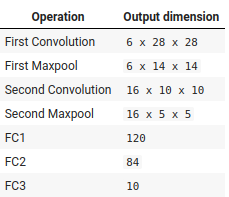</p>

We dropout before activation functions

In [13]:
class Net(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
        self.drop = nn.Dropout(0.2)
        self.normalise = nn.BatchNorm2d(6)

    def forward(self, x):
      # Forward pass
        x = self.conv1(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 61 * 61)
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
# model = nn.Sequential()
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         model = nn.Sequential(nn.Conv2d(3,6,5),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2,2),
#                       nn.Conv2d(6, 16, 5),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),
#                       nn.Net(),
#                       nn.Linear(16 * 61 * 61, 120),
#                       nn.ReLU(),
#                       nn.Linear(120, 84),
#                       nn.ReLU(),
#                       nn.Linear(84, 61))
#     def forward(self, x):
#         x = x.view(-1, 16 * 61 * 61)
#         return x


In [14]:
model = Net().to(device)
#Loss Function
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

In [15]:
print(device)

cpu


#### Train Model

In [16]:
n_epochs = 15
valid_loss_min = np.Inf
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
#     scheduler.step()
#     # Print Learning Rate
#     print('Epoch:', epoch,'LR:', scheduler.get_lr())
    model.train()
    for images in trainDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        target = images['labelId'].to(device)
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    
    
    
    model.eval()
    for images in validDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        target = images['labelId'].to(device)
#         forward pass now
        output = model(data)
#         calculate the branch loss
        loss = error(output, target)
#     update average validation loss
        valid_loss += loss.item()*data.size(0)
    
    train_loss /= len(trainDataLoader.sampler)
    valid_loss /= len(validDataLoader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))    
    if valid_loss <= valid_loss_min:
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'InitialPart1.pth')

Epoch: 0 	Training Loss: 3.768901 	Validation Loss: 3.596197
Epoch: 1 	Training Loss: 3.466586 	Validation Loss: 3.448535
Epoch: 2 	Training Loss: 3.226487 	Validation Loss: 3.295477
Epoch: 3 	Training Loss: 2.932669 	Validation Loss: 3.190514
Epoch: 4 	Training Loss: 2.626672 	Validation Loss: 3.214334
Epoch: 5 	Training Loss: 2.331903 	Validation Loss: 3.164894
Epoch: 6 	Training Loss: 2.058194 	Validation Loss: 3.236122
Epoch: 7 	Training Loss: 1.835778 	Validation Loss: 3.341910
Epoch: 8 	Training Loss: 1.650336 	Validation Loss: 3.517481
Epoch: 9 	Training Loss: 1.527927 	Validation Loss: 3.595202
Epoch: 10 	Training Loss: 1.399940 	Validation Loss: 3.815860
Epoch: 11 	Training Loss: 1.302679 	Validation Loss: 3.773102
Epoch: 12 	Training Loss: 1.205028 	Validation Loss: 3.899691
Epoch: 13 	Training Loss: 1.127602 	Validation Loss: 3.985006
Epoch: 14 	Training Loss: 1.081468 	Validation Loss: 4.046238


In [17]:
print(train_losses)
print(valid_losses)
epoch= np.arange(15)
print(epoch)

[3.768900564040043, 3.466585878872619, 3.2264874435362922, 2.9326692264542564, 2.626672256630569, 2.3319031678890316, 2.0581935350881184, 1.8357778473487887, 1.6503357629958835, 1.5279265466524619, 1.3999399813462685, 1.3026793935149008, 1.2050280081936526, 1.127601968952823, 1.0814684709429916]
[3.596196713877338, 3.448535432119738, 3.295477091498641, 3.190514436607197, 3.2143343507987745, 3.164894378236435, 3.2361218264174565, 3.3419104338715515, 3.5174814498475695, 3.59520150663515, 3.815860089314342, 3.773102215942907, 3.899691174470304, 3.9850061809556165, 4.046238068347325]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


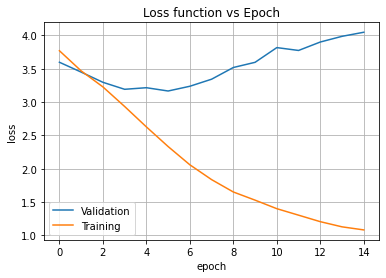

In [18]:
fig, ax = plt.subplots()
ax.plot(epoch, valid_losses,label='Validation')
ax.plot(epoch,train_losses,label='Training')
ax.grid()

ax.set(xlabel='epoch', ylabel='loss',
       title='Loss function vs Epoch')
leg = ax.legend();
fig.savefig("test.png")
plt.show()

In [20]:
model.load_state_dict(torch.load('InitialPart1.pth'))
model.eval()

preds = []
with torch.no_grad():
    for images in testDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
              preds.append(i)

In [23]:
model.load_state_dict(torch.load('InitialPart1.pth'))
model.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
model.to(device)
with torch.no_grad():
    for images in validDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        target = images['labelId'].to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
                pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
              correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20.439914 %


In [21]:
# Create Submission file        
df = pd.DataFrame(Label_Encode.inverse_transform(preds),columns=['ClassName'])
df.to_csv('submissionPart1_2.csv',index=False)

Score with basic model without much optimisations: 0.227
    We observe that there is a lot of overfitting due to the high value of the validation loss
    
Score with basic model and only dropout as seen in plot is 0.200 and 20.43914% 
    Not much overfitting but not too batchnormialised either